In [1]:
import pandas as pd
import numpy as np
import os
import re
from copy import deepcopy 

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#base_dir = 'data/english_only/prompting_results_clean/with_metrics/' #experiment 1
base_dir = 'data/english_only/100k_results/with_metrics/' #experiment 2

In [3]:
from aggregate_metrics_helper import *

In [4]:
os.chdir('/shared/0/projects/research-jam-summer-2024/')
pd.options.mode.copy_on_write = True

In [5]:
os.listdir(base_dir)

['wildchat_subset_en_100k_Mixtral-8x7B_end.jsonl',
 'wildchat_subset_en_100k_Mixtral-8x7B_embeddings.npz',
 'wildchat_subset_en_100k_Mistral-Large-Instruct_POS_DEP.jsonl',
 'human-turn1.grammar-tool-output.csv',
 'wildchat_subset_en_100k_Mistral-Large-Instruct.jsonl',
 'wildchat_subset_en_100k_Llama-3.1-70B_POS_DEP.jsonl',
 'wildchat_subset_en_100k_Mistral-Large-Instruct_end.jsonl',
 'wildchat_subset_en_100k_Mistral-Large-Instruct_individual.jsonl',
 'wildchat_subset_en_100k_Mistral-Large-Instruct_embeddings.npz',
 'wildchat_subset_en_100k_Llama-3.1-70B_end.jsonl',
 'wildchat_subset_en_100k_Mixtral-8x7B_POS_DEP.jsonl',
 'wildchat_subset_en_100k_Mixtral-8x7B.jsonl',
 'wildchat_subset_en_100k_Llama-3.1-70B.jsonl',
 'wildchat_subset_en_100k_Llama-3.1-70B_embeddings.npz']

In [6]:
for f in os.listdir(base_dir):
    if f.startswith('wildchat_subset_en_100k') and not f.endswith('_end.jsonl') and not f.endswith('_embeddings.npz') and not f.endswith('individual.jsonl') and not f.endswith('_POS_DEP.jsonl'):
        print(f)

wildchat_subset_en_100k_Mistral-Large-Instruct.jsonl
wildchat_subset_en_100k_Mixtral-8x7B.jsonl
wildchat_subset_en_100k_Llama-3.1-70B.jsonl


In [8]:
metrics = pd.concat([make_human_vs_llm_df(f, base_dir) 
                     for f in os.listdir(base_dir)
                       if f.startswith('wildchat_subset_en_100k') and 
                       not f.endswith('_end.jsonl') and not f.endswith('_embeddings.npz') and 
                       not f.endswith('individual.jsonl') and 
                       not f.endswith('_POS_DEP.jsonl')]).reset_index(drop=True)

wildchat_subset_en_100k_Mistral-Large-Instruct.jsonl
read metrics
read dependency parse metrics
read embeddings
wildchat_subset_en_100k_Mixtral-8x7B.jsonl
read metrics


/opt/anaconda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


read dependency parse metrics
read embeddings
wildchat_subset_en_100k_Llama-3.1-70B.jsonl
read metrics


/opt/anaconda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


read dependency parse metrics
read embeddings


In [9]:
# log scale heavy-tailed count metrics
for k in ['word_count', 'word_length', 'perplexity', 
          'dep_dpth', 'dep_brth', 'dep_dep_dist'
         ]:
    metrics['human_'+k] = np.log(metrics['human_'+k]+1)
    metrics['llm_'+k] = np.log(metrics['llm_'+k]+1)

In [10]:
# check that columns are exactly the merge keys and human/llm metrics from all_metrics 

print(Counter(['human_'+k in metrics.columns for k in all_metrics]))
print(Counter(['llm_'+k in metrics.columns for k in all_metrics]))
print(Counter([k in metrics.columns for k in merge_keys]))
print(Counter([k in merge_keys or re.sub('human_|llm_','',k) in all_metrics 
               for k in metrics.columns]))


Counter({True: 20})
Counter({True: 20})
Counter({True: 4})
Counter({True: 44})


In [12]:
def zscore_metric(p=1):
    print(p)
    
    # CREATE NORMALIZED SIMILARITIES BY Z-SCORE
    df_zscore = metrics[merge_keys]
    for k in all_metrics:
        df_zscore.loc[:,'zscore_'+k] = diff_zscore(metrics['human_'+k], metrics['llm_'+k], all_metrics[k], p)
        #sns.kdeplot(df_zscore['zscore_'+k])
        #plt.show()

    # AGGREGATED SCORES VIA Z-SCORE
    agg = aggregate_scores(df_zscore, method = 'zscore')
    agg['p'] = p
    return agg

1


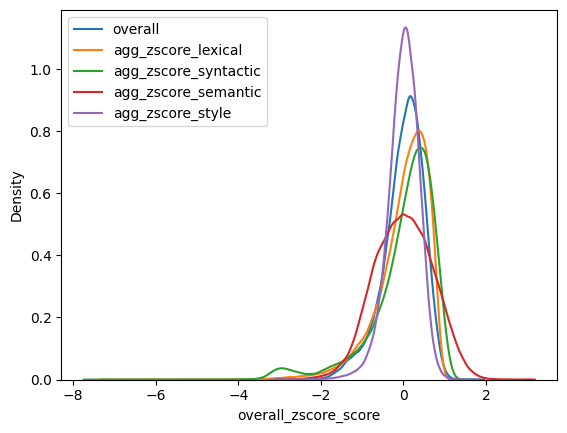

In [13]:
row_zscore = zscore_metric(p=1)

In [14]:
row_zscore.to_csv('data/agg_metrics/wildchat_subset_en_100k_all_metrics_agg.csv', index=None)


In [15]:
row_zscore.to_json('data/wildchat_subset_en_100k_all_normalized_metrics.jsonl', 
                   orient='records', lines=True)

In [16]:
# CREATE COLUMN AGGREGATES WITH CORRELATION
def corr_metric(corr_method='pearson'):
    model = []
    metric = []
    cor = []
    for mod in set(metrics.model):
        print(mod)
        sub = metrics[metrics.model == mod]
        for k in all_metrics:
            model.append(mod)
            metric.append(k)
            cor.append(col_diff_correlate(sub['human_'+k], sub['llm_'+k], all_metrics[k], corr_method))
    col_corr = pd.DataFrame({'model': model, 'metric': metric, 'cor': cor, 'corr_method': corr_method})
    col_corr['category'] = col_corr['metric'].replace(metric_category)
    return col_corr

In [17]:
col_corr = corr_metric('pearson')

wildchat_subset_en_100k_Llama-3.1-70B
wildchat_subset_en_100k_Mixtral-8x7B
wildchat_subset_en_100k_Mistral-Large-Instruct


In [18]:
col_corrs = {m: corr_metric(m) for m in ['pearson','spearman','kendall']}

wildchat_subset_en_100k_Llama-3.1-70B
wildchat_subset_en_100k_Mixtral-8x7B
wildchat_subset_en_100k_Mistral-Large-Instruct
wildchat_subset_en_100k_Llama-3.1-70B
wildchat_subset_en_100k_Mixtral-8x7B
wildchat_subset_en_100k_Mistral-Large-Instruct
wildchat_subset_en_100k_Llama-3.1-70B
wildchat_subset_en_100k_Mixtral-8x7B
wildchat_subset_en_100k_Mistral-Large-Instruct
